<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural

Alumno: Ignacio de Pedro

## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [4]:
import re

import numpy as np
import pandas as pd


import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input

In [5]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 70.2MB/s]


In [6]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [7]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [8]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [9]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento

Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

#### Tokenización

- Se tokenizan ahora las palabras.
- Al ser todas en inglés, se utiliza un solo tokenizador.
- Se limita el tamaño máximo del vocabulario con MAX_VOCAB_SIZE para evitar problemas de RAM.

In [10]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 5000
# Voy a necesitar un tokenizador único ya que estamos en el mismo idioma

# Tokenizar las palabras de entrada con el Tokenizer de Keras
# sacamos los "<>" para que no afectar nuestros tokens
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,filters='!"#$%&()*+,-./:;=¿@[\\]^_`{|}~\t\n')

# El fit se realiza sobre los conjuntos de input y output porque puede existir el mismo término en entrada y salida
tokenizer.fit_on_texts(["<sos>", "<eos>"] + input_sentences + output_sentences) # Ver explicación de arriba


word2idx = tokenizer.word_index
vocab_size = len(word2idx) + 1 #Se agrega 1 para los caracteres desconocidos
print("Palabras en el vocabulario:", vocab_size)

# Tokenizar las palabras de entrada
input_integer_seq = tokenizer.texts_to_sequences(input_sentences)
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

# Tokenizar las palabras de salida
output_integer_seq = tokenizer.texts_to_sequences(output_sentences)
max_output_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de salida más larga:", max_output_len)

# Tokenizar las palabras de input/output que entran en el decoder
output_input_integer_seq = tokenizer.texts_to_sequences(output_sentences_inputs)

Palabras en el vocabulario: 2158
Sentencia de entrada más larga: 9
Sentencia de salida más larga: 9


Definimos los tamaños máximos de las oraciones de entrada y salida

In [13]:
input_sentences_lengths = [len(x) for x in input_integer_seq]
input_sentences_lengths_set = set(input_sentences_lengths)
print(input_sentences_lengths_set)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [17]:
#Como el tamaño máximo es solamente 9 probamos con dicho valor
max_input_len = max(len(sen) for sen in input_integer_seq)
max_input_len

9

Se repite mismo análisis para las salidas

In [16]:
output_sentences_lengths = [len(x) for x in output_integer_seq]
output_sentences_lengths_set = set(output_sentences_lengths)
print(output_sentences_lengths_set)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


In [19]:
#Como el tamaño máximo es solamente 10 probamos con dicho valor
max_output_len = max(len(sen) for sen in output_integer_seq)
max_output_len

10

#### Padding

A la hora de realiza padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [23]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_output_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)


Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 9)
decoder_input_sequences shape: (6033, 10)


La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

In [24]:
from tensorflow.keras.utils import pad_sequences,plot_model, to_categorical

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_output_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=vocab_size)
decoder_targets.shape

(6033, 10, 2158)

### 3 - Preparar los embeddings

Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [25]:
# Descarga de los embeddings
import os
import gdown

if os.access('cc.en.300.vec', os.F_OK) is False:
  !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
  !gunzip cc.en.300.vec.gz
# Check
!ls -lh cc.en.300.vec


if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

--2025-04-24 04:47:45--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.74, 18.173.166.48, 18.173.166.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G   110MB/s    in 13s     

2025-04-24 04:47:58 (97.3 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]

-rw-r--r-- 1 root root 4.3G Jan 18  2019 cc.en.300.vec


Downloading...
From (original): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t&uuid=072a2097-919b-4985-b3aa-6a31d0bcec5f
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:06<00:00, 85.9MB/s]


In [26]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60


Tal como se recomendó en clase, se utilizan los embeddings de FastText para transformar los tokens de entrada en vectores

In [27]:
model_embeddings = FasttextEmbeddings()

In [28]:
# Crear la Embedding matrix de las secuencias
print('Preparando matriz de embeddings...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer
nb_words = min(MAX_VOCAB_SIZE+1, len(word2idx)+1) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # Las palabras que no se encuentren en Glove o FastTest se inicializan con ceros
        words_not_found.append(word)
        print(f"Palabra {word}, no encontrada en los embeddings")

print('Number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

Preparando matriz de embeddings...
Number of null word embeddings: 1


In [30]:
# Dimensión de los embeddings (2158, 300)
embedding_matrix.shape


(2158, 300)

### 4 - Entrenar el modelo

Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

#### Definicion del modelo

- Dropout con probabilidad de 0.2
- LSTM con 256 unidades.

In [31]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

n_units = 256
dropout = 0.2

# define training encoder
encoder_inputs = Input(shape=[max_input_len])

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, dropout=dropout, recurrent_dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=[max_output_len])

decoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_output_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, dropout=dropout, recurrent_dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(nb_words, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 9, 300)    │    647,400 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 10, 300)   │    647,400 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    570,368 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 10, 256), │    570,368 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 2158)  │    554,606 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,990,142 (11.41 MB)

 Trainable params: 1,695,342 (6.47 MB)

 Non-trainable params: 1,294,800 (4.94 MB)

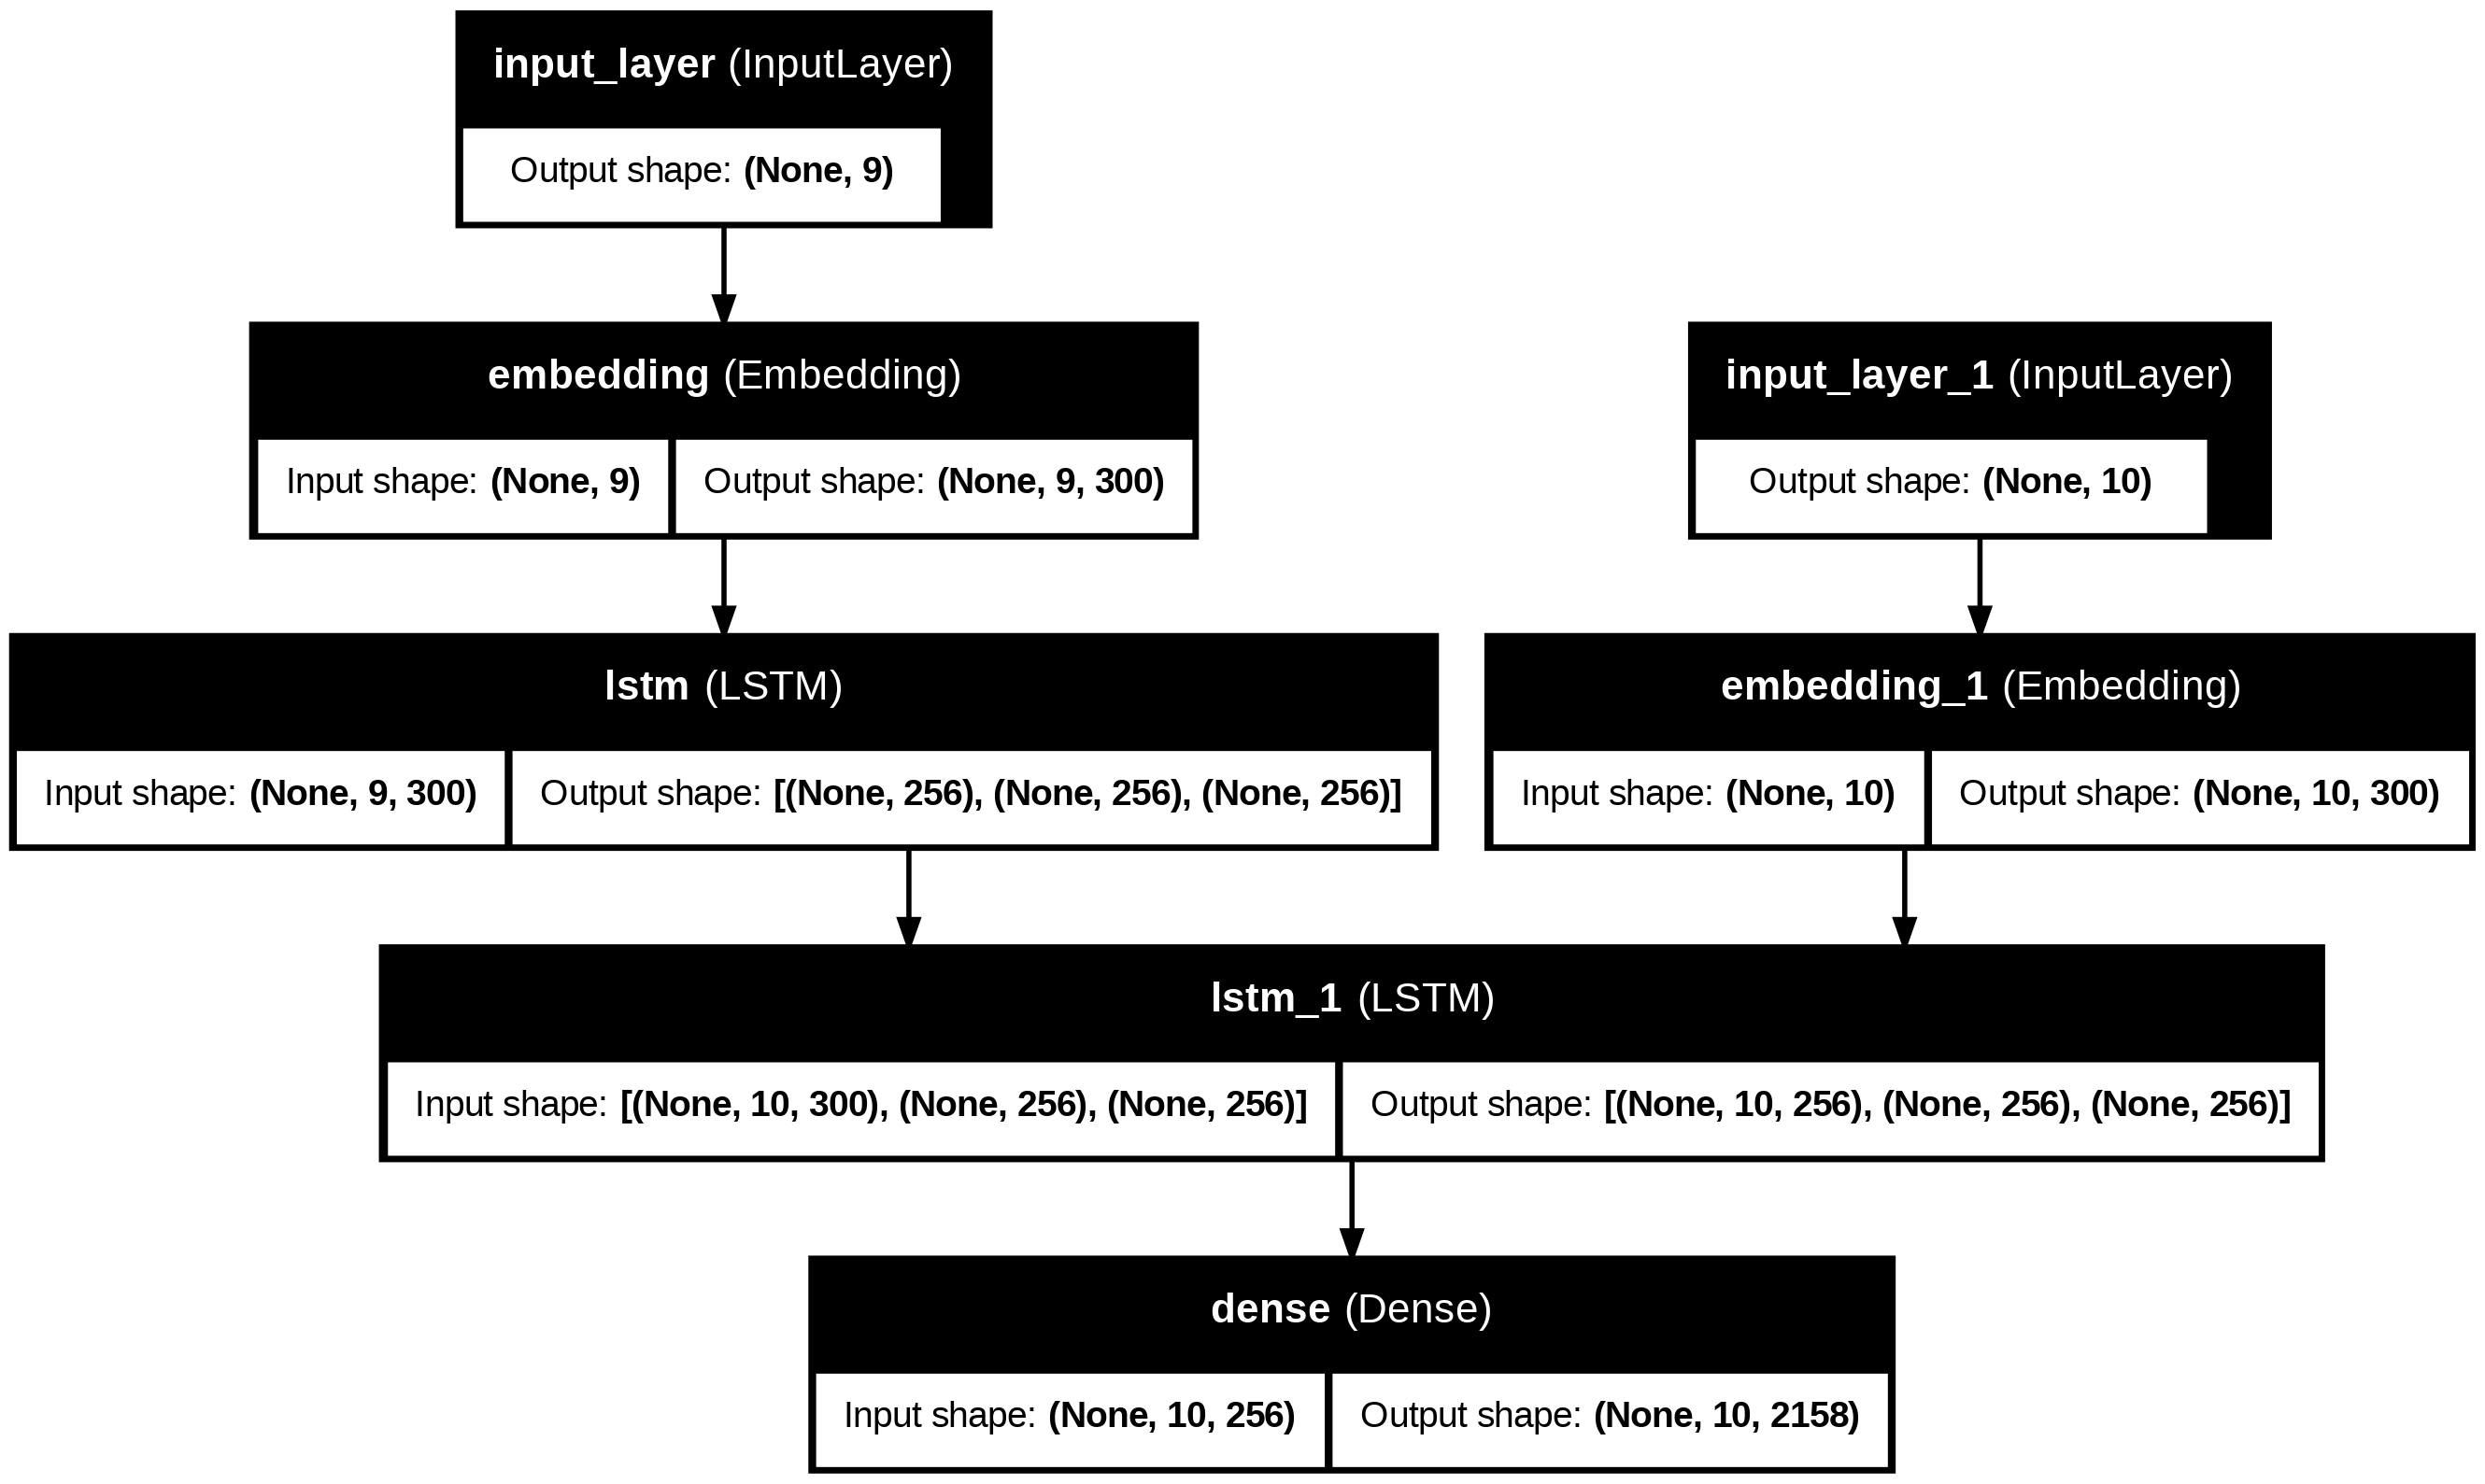

In [32]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

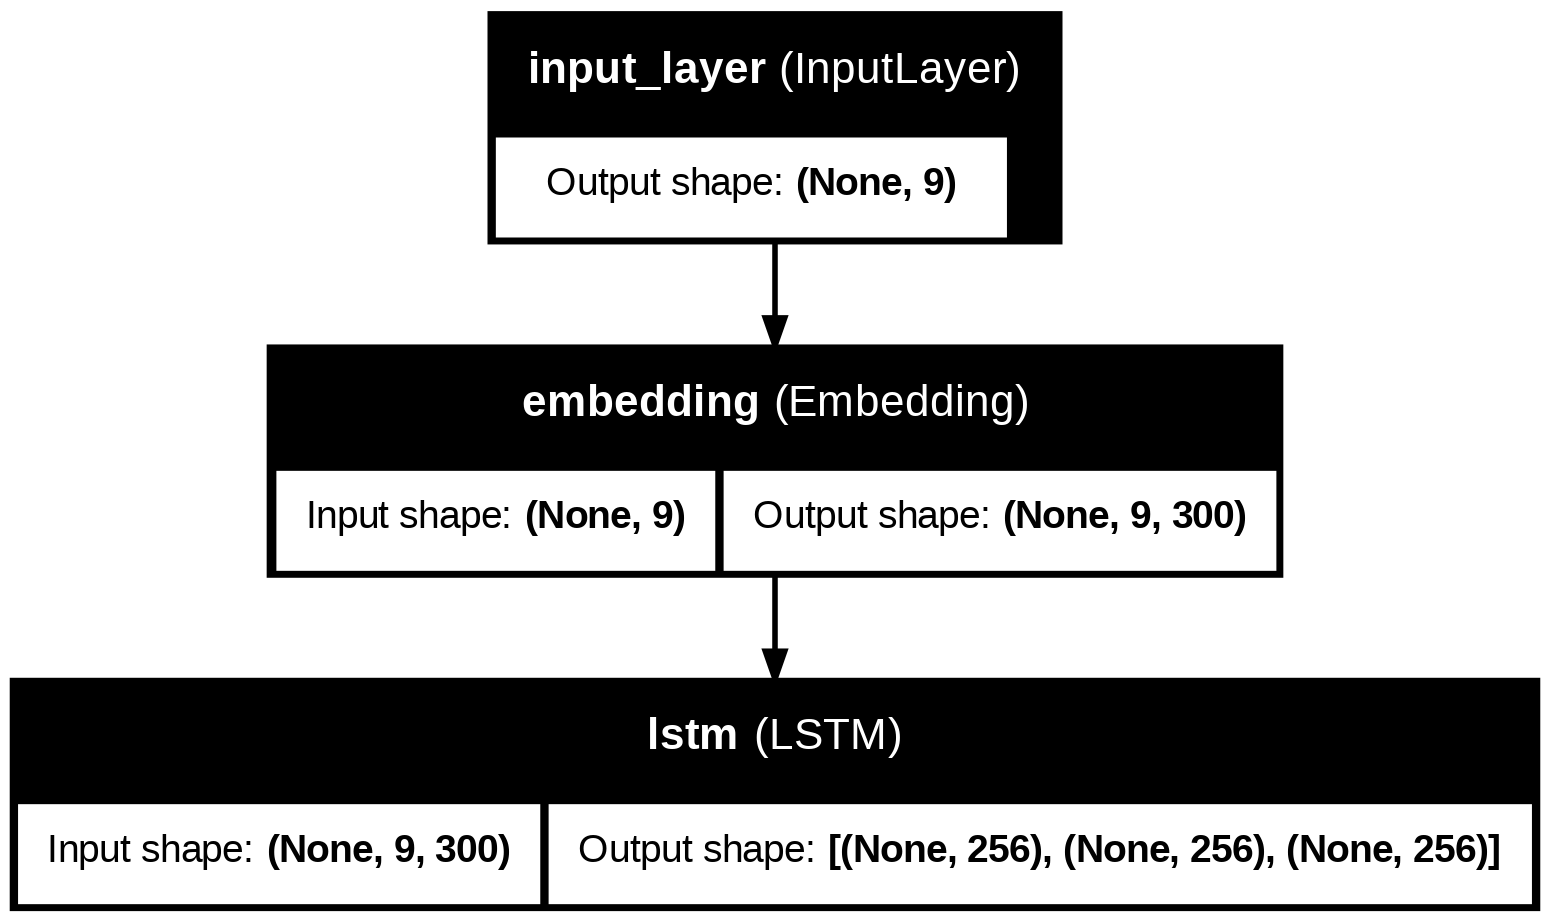

In [33]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

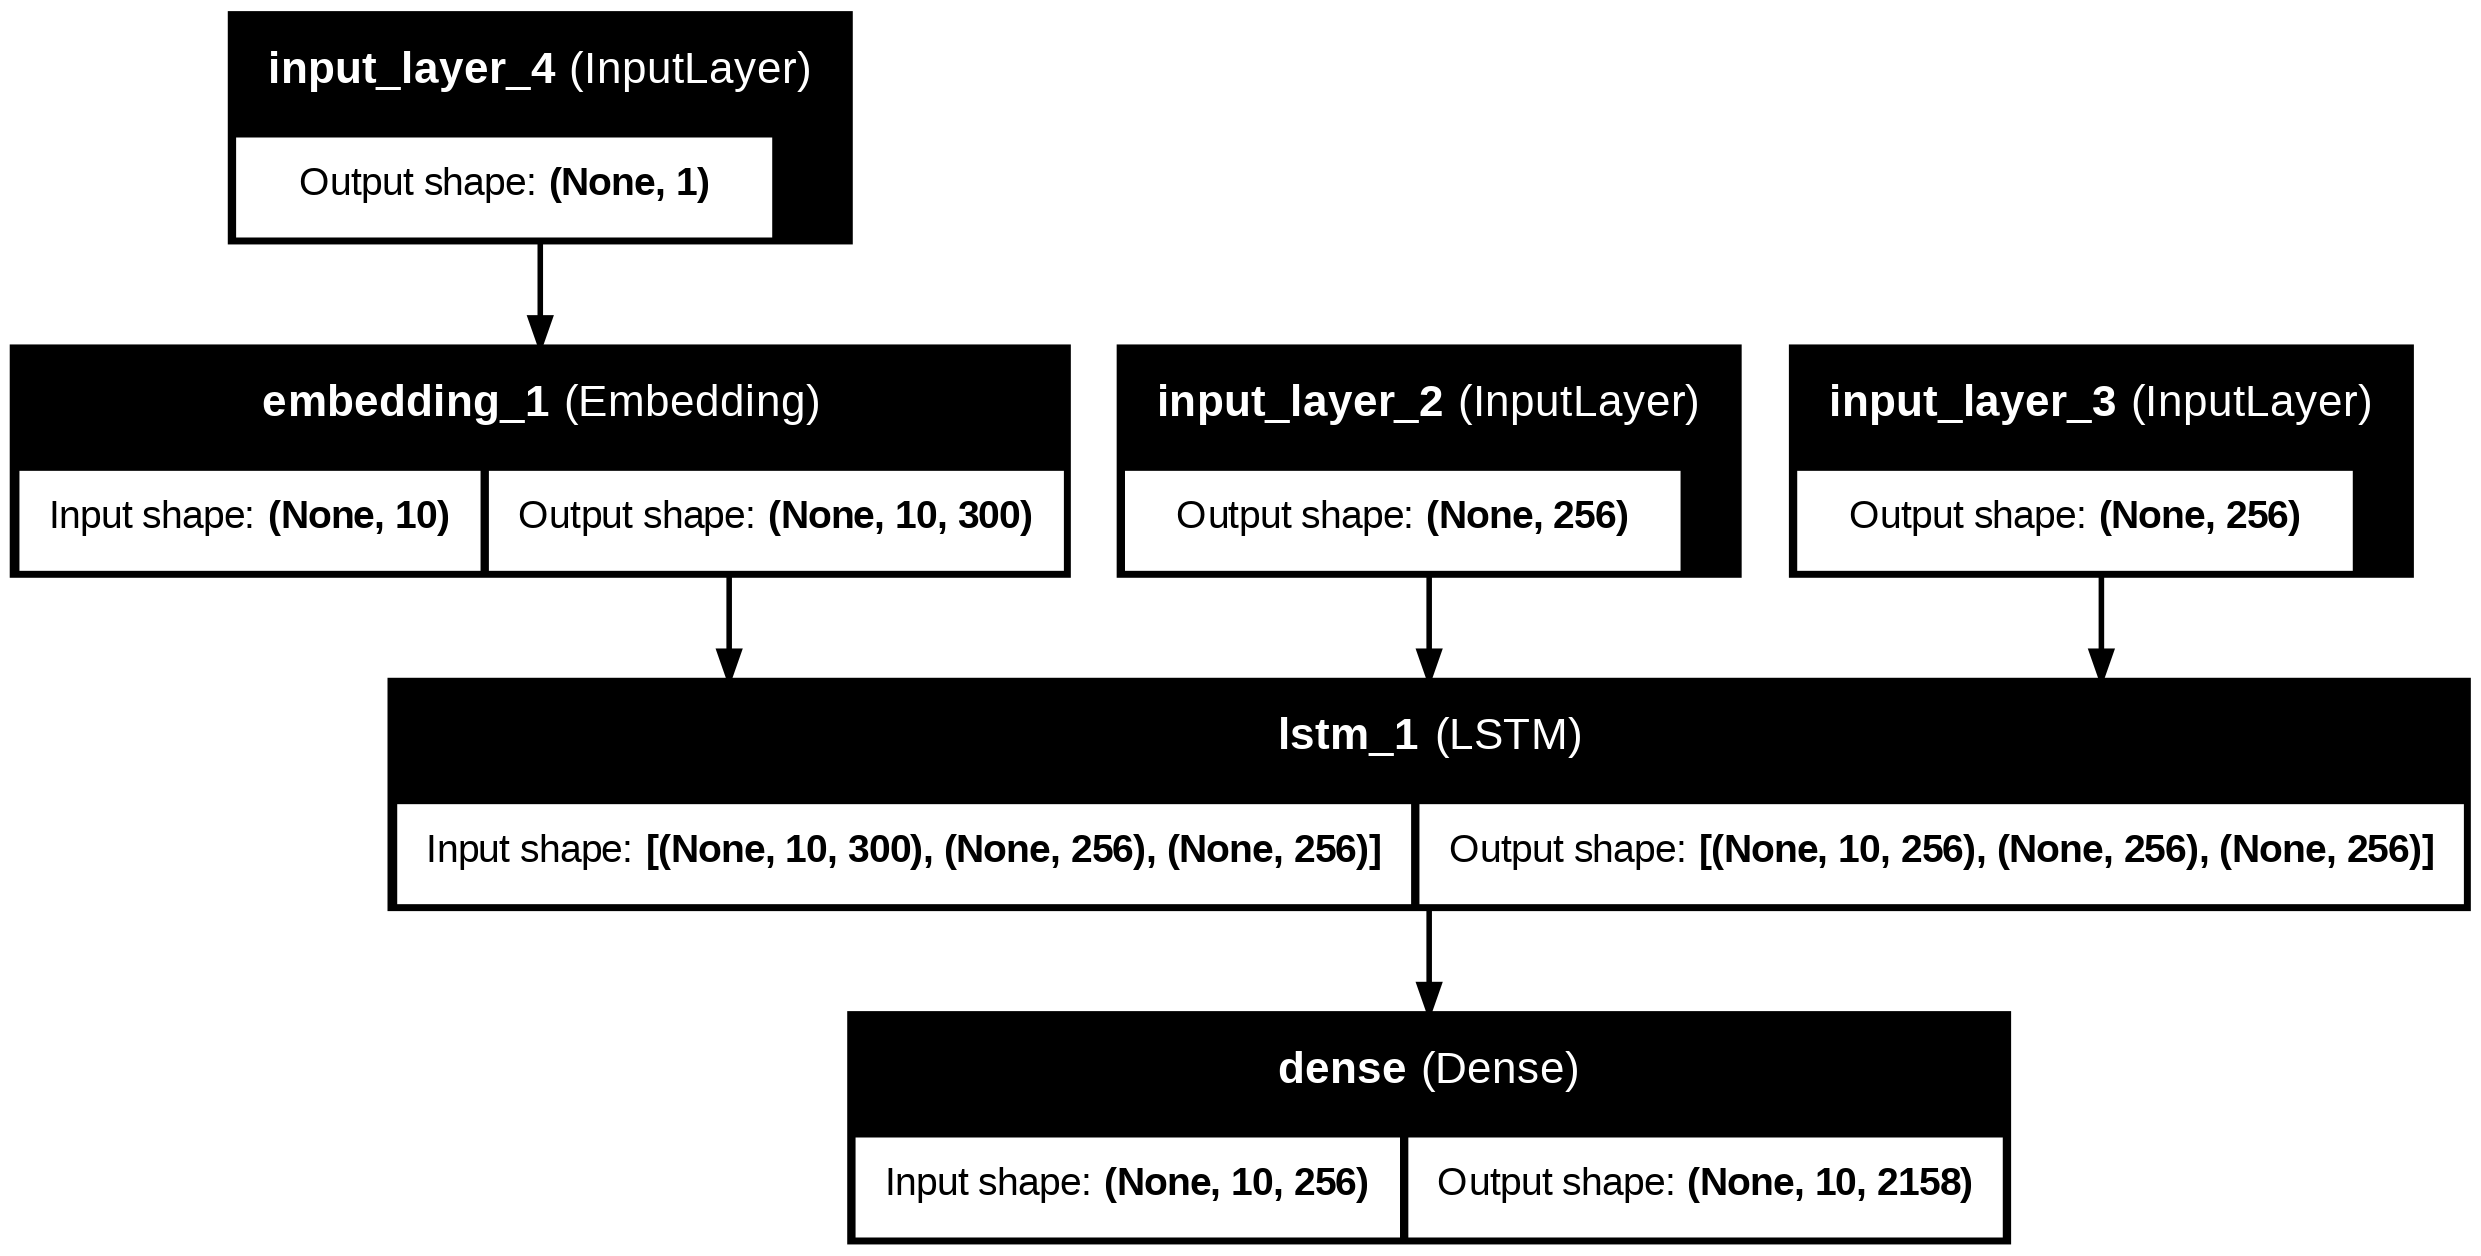

In [34]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [35]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - accuracy: 0.5185 - loss: 3.5450 - val_accuracy: 0.6628 - val_loss: 2.0809
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.6808 - loss: 1.8221 - val_accuracy: 0.6838 - val_loss: 1.9088
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.7032 - loss: 1.6579 - val_accuracy: 0.6908 - val_loss: 1.8429
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.7175 - loss: 1.5245 - val_accuracy: 0.6971 - val_loss: 1.8037
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.7194 - loss: 1.4915 - val_accuracy: 0.7018 - val_loss: 1.7796
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.7245 - loss: 1.4328 - val_accuracy: 0.7027 - val_loss: 1.7685
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.7329 - loss: 1.3681 - val_accuracy: 0.7044 - val_loss: 1.7589
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.7315 - loss: 1.3362 - 

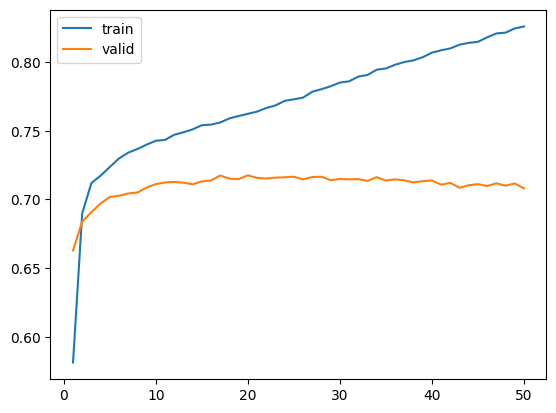

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [37]:
# Armar los conversores de índice a palabra:
idx2word = {v:k for k, v in word2idx.items()}

In [44]:
def response(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx['<eos>']

    output_sentence = []
    for _ in range(max_output_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [62]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
res = response(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
-
Input: any pets 
Response: i have a lot of friends


#### Preguntas de prueba

- a. What do you do for a living?
- b. Do you read?
- c. Do you have any pet?
- d. What is your name?

In [46]:
def answer_question(input_text, quiet=False):
    integer_seq = tokenizer.texts_to_sequences([input_text])[0]
    encoder_sequence = pad_sequences([integer_seq], maxlen=max_input_len)
    res = response(encoder_sequence)
    if not quiet:
      print("Representacion en vector de tokens de ids", integer_seq)
      print("Padding del vector:", encoder_sequence)
      print('Input:', input_text)
      print('Response:', res)
    return res

In [60]:
res = answer_question("What do you do for a living?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Representacion en vector de tokens de ids [5, 4, 3, 4, 9, 6]
Padding del vector: [[0 0 0 5 4 3 4 9 6]]
Input: What do you do for a living?
Response: i work at a grocery store


In [55]:
res = answer_question("Do you read?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Representacion en vector de tokens de ids [4, 3]
Padding del vector: [[0 0 0 0 0 0 0 4 3]]
Input: Do you read?
Response: yes i do i am a girl


In [56]:
res = answer_question("Do you have any pet?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Representacion en vector de tokens de ids [4, 3, 16, 30]
Padding del vector: [[ 0  0  0  0  0  4  3 16 30]]
Input: Do you have any pet?
Response: i do not have any


In [61]:
res = answer_question("What is your name?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Representacion en vector de tokens de ids [5, 15, 20]
Padding del vector: [[ 0  0  0  0  0  0  5 15 20]]
Input: What is your name?
Response: dharmik you like


### 6. Conclusiones:

Como conclusiones del presente trabajo práctico podemos establecer los siguientes razonamientos:

- Las respuestas generadas a partir de las preguntas interesantes propuestas en clase tienen sentido semántico y sintáctico. Sin emabargo, para el caso de la oración obtenida de forma aleatoria, la misma pierde sentido. Es importante aclarar que solamente se usaron 5000 pares de preguntas/respuestas, lo cual puede llegar a ser poco para este tipo de problemas.

- A partir del gráfico obtenido a luego del entranamiento, se observa un overfitting a partir de la divergencia entre "train" y "valid". Por lo que se podría experimentar con un nuevo valor de dropout, o algun otro elemento de regularización.


